# Downloading the required data

In [ ]:
mkdir Particle_images

mkdir: cannot create directory ‘Particle_images’: File exists


In [ ]:
cd Particle_images

/content/Particle_images


In [ ]:
mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2020-10-30 21:49:15--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.26, 137.138.120.151, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  21.9MB/s    in 3.8s    

Last-modified header invalid -- time-stamp ignored.
2020-10-30 21:49:20 (21.9 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2020-10-30 21:49:20--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.26, 137.138.120.151, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (

Creating DataLoaders for PyTorch

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import h5py
import numpy as np
 
def load_data(decays):
    dsets = [h5py.File('%s'%(decay)) for decay in decays]
    X = np.concatenate([dset['/X'] for dset in dsets])
    y = np.concatenate([dset['/y'] for dset in dsets])
    assert len(X) == len(y)
    return X, y
 
paths = [r'/content/Particle_images/data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', r'/content/Particle_images/data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5']
X, y = load_data(paths)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if __name__ == '__main__':


In [ ]:
## Custom Dataset

class ImgDataset(Dataset):
    def __init__(self, images, labels):
        self.labels = labels
        self.images = images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.images[idx, :, :, :]
        labels = self.labels[idx]
        sample = [torch.from_numpy(images).reshape(2, 32, 32), torch.tensor(labels)]
        return sample

In [ ]:
dataset = ImgDataset(X, y)
dataset[0][0].shape

torch.Size([2, 32, 32])

In [ ]:
trainset, testset = torch.utils.data.random_split(dataset, [400000, 23300])
testset, valset = torch.utils.data.random_split(testset, [11650, 11650])

In [ ]:
## Creating Dataloaders 

train_dl = DataLoader(trainset, batch_size= 1024, shuffle= True, num_workers= 4, pin_memory=True)
test_dl = DataLoader(testset, batch_size= 1024, shuffle= True, num_workers= 4, pin_memory=True)
val_dl = DataLoader(valset, batch_size= 1024, shuffle= True, num_workers= 4, pin_memory=True)

In [ ]:
## Helper functions to help use cuda for training

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
## Wrapping the DataLoader to add GPU support

train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

# Model:

In [ ]:
import torch.nn as nn

model1 = torchvision.models.resnet50(pretrained=True)


# model1.features._modules['0'] = nn.Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model1.fc = nn.Linear(in_features=2048, out_features=1000, bias=True)
model1.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model1 = model1.to(device)
model1

ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchsummary import summary 

summary(model1, (2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           6,272
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

# Evaluation and fit functions

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

def evaluate(model, val_dl):
    model.eval()
    val_acc, val_loss = [], []
    for batch in val_dl:
        img, labels = batch
        # img = img.to(device)
        # labels = labels.to(device)
        with torch.no_grad():
            out = model(img)
            loss = F.cross_entropy(out, labels.long())
            acc = accuracy(out, labels)
            val_loss.append(loss.detach())
            val_acc.append(acc)
    return sum(val_loss)/len(val_loss), sum(val_acc)/len(val_acc)



def fit(model, epochs, train_dl, validation_dl, lr=1e-3):

    optimizer= torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    print("Start of training")
    train_acc, train_loss, val_acc, val_loss= [], [], [], []

    for epoch in range(epochs):
        
        epoch_loss, epoch_acc = [], []

        for batch in train_dl:
            model.train()
            img, labels = batch
            # img = img.to(device)
            # labels = labels.to(device)
            out = model(img)
            loss = F.cross_entropy(out, labels.long())
            acc = accuracy(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss.append(loss)
            epoch_acc.append(acc)
            
        
        train_loss.append(sum(epoch_loss)/len(epoch_loss))
        train_acc.append(sum(epoch_acc)/len(epoch_acc))

        vald_loss, vald_acc  = evaluate(model, val_dl)

        val_acc.append(vald_acc)
        val_loss.append(vald_loss)

        print(f'Epoch: {epoch+1}/{epochs} -- Train Loss: {sum(epoch_loss)/len(epoch_loss)} -- Train Acc: {sum(epoch_acc)/len(epoch_acc)} -- Val Loss: {vald_loss} -- Val Acc: {vald_acc}') 
    
    return {"train_loss": train_loss , "train_acc" : train_acc, "val_loss" : val_loss, "val_acc": val_acc}

# Training phase

In [ ]:
# Before training
l, a = evaluate(model1, train_dl)
print(f"Training loss = {l}, Training accuracy = {a}")
print("========================================")
l, a = evaluate(model1, val_dl)
print(f"Validation loss = {l}, Validation accuracy = {a}")
print("========================================")
l, a = evaluate(model1, test_dl)
print(f"Test loss = {l}, Test accuracy = {a}")

Training loss = 7.727512836456299, Training accuracy = 0.0
Validation loss = 7.7262163162231445, Validation accuracy = 0.0
Test loss = 7.726391792297363, Test accuracy = 0.0


In [ ]:
# model1 = torch.load("/content/entire_model.pth")

In [ ]:
# model1.load_state_dict(torch.load("/content/stdict.pth"))
# model1.eval()

In [ ]:
# Training cell, do not run if using pre-trained model

import datetime

start = datetime.datetime.now()

history = fit(model1, 5, train_dl, val_dl);

print(datetime.datetime.now()-start)

Start of training
Epoch: 1/5 -- Train Loss: 0.7085142135620117 -- Train Acc: 0.6010475158691406 -- Val Loss: 0.6431437730789185 -- Val Acc: 0.6297124624252319
Epoch: 2/5 -- Train Loss: 0.6128876805305481 -- Train Acc: 0.6698169708251953 -- Val Loss: 0.5950013995170593 -- Val Acc: 0.6919594407081604
Epoch: 3/5 -- Train Loss: 0.586223304271698 -- Train Acc: 0.697813093662262 -- Val Loss: 0.5779231786727905 -- Val Acc: 0.7022268772125244
Epoch: 4/5 -- Train Loss: 0.5739535689353943 -- Train Acc: 0.7084084153175354 -- Val Loss: 0.5706934332847595 -- Val Acc: 0.7137976288795471
Epoch: 5/5 -- Train Loss: 0.5665310025215149 -- Train Acc: 0.7152404189109802 -- Val Loss: 0.6149156093597412 -- Val Acc: 0.7010027766227722
0:27:06.607409


In [ ]:
# After training
model1.eval()
l, a = evaluate(model1, train_dl)
print(f"Training loss = {l}, Training accuracy = {a}")
print("========================================")
l, a = evaluate(model1, val_dl)
print(f"Validation loss = {l}, Validation accuracy = {a}")
print("========================================")
l, a = evaluate(model1, test_dl)
print(f"Test loss = {l}, Test accuracy = {a}")

Training loss = 0.6073602437973022, Training accuracy = 0.7011693716049194
Validation loss = 0.6143066883087158, Validation accuracy = 0.7019443511962891
Test loss = 0.6098386645317078, Test accuracy = 0.6970615386962891


# Evaluation Phase

In [ ]:
from sklearn.metrics import roc_curve, auc
model1.eval()
# Compute ROC curve and ROC area on validation set

for batch in val_dl:
    input, label = batch
    break

target = label.cpu().numpy()

curve_out = model1(input)
_, pred = torch.max(curve_out, dim=1)

y_score = pred.cpu().numpy()

fpr, tpr, _ = roc_curve(target, y_score)
roc_auc= auc(fpr, tpr)

print(f'Val roc_auc = {roc_auc}')

# Compute ROC curve and ROC area on test set

for batch in test_dl:
    input, label = batch
    break
    
target = label.cpu().numpy()

curve_out = model1(input)
_, pred = torch.max(curve_out, dim=1)

y_score = pred.cpu().numpy()

fpr, tpr, _ = roc_curve(target, y_score)
roc_auc= auc(fpr, tpr)
print(f'Test roc_auc = {roc_auc}')

Val roc_auc = 0.7130681818181818
Test roc_auc = 0.6994888227664605


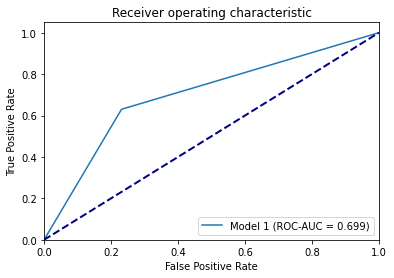

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
lw = 2
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# plt.plot([0, 1], [0, 1], 'k--')
# #plt.legend(loc=2, prop={'size': 15})
# plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

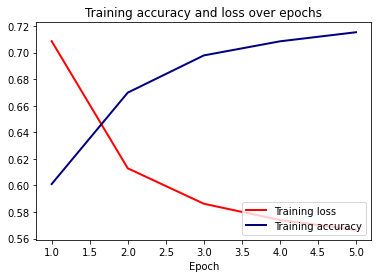

In [ ]:
n_epochs = len(history["train_loss"])

plt.figure()
plt.plot(range(1,n_epochs+1), history["train_loss"], label="Training loss", color = "red", lw=2)
plt.plot(range(1,n_epochs+1), history["train_acc"], label="Training accuracy", color = "navy", lw=2)
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Training accuracy and loss over epochs')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure()
plt.plot(range(1,n_epochs+1), history["val_loss"], label="Val loss", color = "red", lw=2)
plt.plot(range(1,n_epochs+1), history["val_acc"], label="Val accuracy", color = "navy", lw=2)
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Validation accuracy and loss over epochs')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model1.eval()
torch.save(model1.state_dict(), "/content/stdict.pth")

In [ ]:
model1.eval()
torch.save(model1, "/content/entire_model.pth")